<a href="https://colab.research.google.com/github/Hami-611/21Days_AI-ML_Challenge/blob/main/Day_12_Real_World_Computer_Vision_Building_a_Real_Time_Object_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment: Face Resolution Enhancement

**Goal:** The objective of this assignment is to implement a solution that takes a low-resolution face image (64x64 pixels) as input and produces a high-resolution, enhanced face image (256x256 pixels) using a UNET model.

This assignment is based on the concepts and techniques demonstrated in the following Kaggle notebook:

[https://www.kaggle.com/code/ashishjangra27/face-resolution-enhancement-with-unet](https://www.kaggle.com/code/ashishjangra27/face-resolution-enhancement-with-unet)

You will need to refer to this resource to understand how to:

1.  Load or define the UNET model architecture.
2.  Load and preprocess the input image to the required 64x64 size.
3.  Apply the UNET model to the input image.
4.  Handle the output to obtain the 256x256 enhanced image.
5.  (Optional but recommended) Display both the original 64x64 image and the resulting 256x256 image for comparison.

This assignment focuses on applying the knowledge gained from the provided resource to a specific image enhancement task.

## Import Libraries

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint
import kagglehub
import random

## Download Dataset

In [4]:
# Download dataset via KaggleHub
dataset_path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
print("Dataset downloaded at:", dataset_path)

# Path to actual high-resolution images
highres_dir = os.path.join(dataset_path, "img_align_celeba", "img_align_celeba")
print("High-resolution images directory:", highres_dir)

Using Colab cache for faster access to the 'celeba-dataset' dataset.
Dataset downloaded at: /kaggle/input/celeba-dataset
High-resolution images directory: /kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba


In [5]:
# Check the contents of the downloaded directory
import os
print(os.listdir(dataset_path))

['list_landmarks_align_celeba.csv', 'img_align_celeba', 'list_eval_partition.csv', 'list_attr_celeba.csv', 'list_bbox_celeba.csv']


In [6]:
# Check the contents of the highres_dir
import os
print(os.listdir(highres_dir)[:10]) # Print first 10 files to avoid flooding the output

['083648.jpg', '168202.jpg', '125778.jpg', '059339.jpg', '032501.jpg', '160139.jpg', '046754.jpg', '178961.jpg', '123482.jpg', '039337.jpg']


In [7]:
highres_dir = os.path.join(dataset_path, "img_align_celeba", "img_align_celeba")
print("High resolution images directory:", highres_dir)

High resolution images directory: /kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba


## Prepare Image List and Subset

In [23]:
import random

# List only actual images
image_files = [f for f in os.listdir(highres_dir)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"Found {len(image_files)} images in total.")

# Take a small subset for quick Colab training
subset_size = 100
image_files = random.sample(image_files, subset_size)
print(f"Using {len(image_files)} images for training.")



Found 202599 images in total.
Using 100 images for training.


## Define Data Generator

In [24]:
import tensorflow as tf
import cv2
import os
import numpy as np

highres_dir = os.path.join('/kaggle/input/celeba-dataset', "img_align_celeba", "img_align_celeba")
image_files = [f for f in os.listdir(highres_dir)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

def data_generator(batch_size=8):
    while True:
        batch_lr = []
        batch_hr = []
        for filename in image_files:
            path = os.path.join(highres_dir, filename)
            img_hr = cv2.imread(path)
            if img_hr is None:
                continue
            img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
            img_hr = cv2.resize(img_hr, (256,256))
            img_lr = cv2.resize(img_hr, (64,64))

            img_hr = img_hr.astype('float32') / 255.0
            img_lr = img_lr.astype('float32') / 255.0

            batch_lr.append(img_lr)
            batch_hr.append(img_hr)

            if len(batch_lr) == batch_size:
                yield (np.array(batch_lr), np.array(batch_hr))
                batch_lr, batch_hr = [], []





## Define the UNET Model

In [25]:
def unet_superres(input_size=(64,64,3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64,3,activation='relu',padding='same')(inputs)
    conv1 = Conv2D(64,3,activation='relu',padding='same')(conv1)
    pool1 = MaxPooling2D(2)(conv1)

    conv2 = Conv2D(128,3,activation='relu',padding='same')(pool1)
    conv2 = Conv2D(128,3,activation='relu',padding='same')(conv2)
    pool2 = MaxPooling2D(2)(conv2)

    # Bottleneck
    conv3 = Conv2D(256,3,activation='relu',padding='same')(pool2)
    conv3 = Conv2D(256,3,activation='relu',padding='same')(conv3)

    # Decoder
    up1 = UpSampling2D(2)(conv3)
    up1 = Concatenate()([up1, conv2])
    conv4 = Conv2D(128,3,activation='relu',padding='same')(up1)
    conv4 = Conv2D(128,3,activation='relu',padding='same')(conv4)

    up2 = UpSampling2D(2)(conv4)
    up2 = Concatenate()([up2, conv1])
    conv5 = Conv2D(64,3,activation='relu',padding='same')(up2)
    conv5 = Conv2D(64,3,activation='relu',padding='same')(conv5)

    # Upsample to 256x256
    up3 = UpSampling2D(4)(conv5)
    conv6 = Conv2D(64,3,activation='relu',padding='same')(up3)
    outputs = Conv2D(3,3,activation='sigmoid',padding='same')(conv6)

    return Model(inputs, outputs)


## Define Perceptual Loss

In [26]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

vgg = VGG19(include_top=False, weights='imagenet', input_shape=(256,256,3))
vgg.trainable = False
feature_extractor = Model(inputs=vgg.input, outputs=vgg.get_layer("block5_conv4").output)

mse = tf.keras.losses.MeanSquaredError()

def perceptual_loss(y_true, y_pred):
    pixel_loss = mse(y_true, y_pred)
    feature_loss = mse(feature_extractor(y_true), feature_extractor(y_pred))
    return pixel_loss + 0.01*feature_loss

## Compile and Train the Model

In [28]:
batch_size = 8
steps_per_epoch = subset_size  // batch_size

model = unet_superres()
model.compile(optimizer=Adam(1e-4), loss=perceptual_loss)

checkpoint = ModelCheckpoint("unet_face_superres_best.h5", monitor='loss',
                             save_best_only=True, verbose=1)

model.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    callbacks=[checkpoint]
)


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - loss: 0.0919 
Epoch 1: loss improved from inf to 0.09065, saving model to unet_face_superres_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 354s 29s/step - loss: 0.0918
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - loss: 0.0914 
Epoch 2: loss improved from 0.09065 to 0.08264, saving model to unet_face_superres_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 346s 29s/step - loss: 0.0907
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - loss: 0.0475 
Epoch 3: loss improved from 0.08264 to 0.04186, saving model to unet_face_superres_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 347s 29s/step - loss: 0.0470
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - loss: 0.0319 
Epoch 4: loss improved from 0.04186 to 0.02996, saving model to unet_face_superres_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 346s 29s/step - loss: 0.0318
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - loss: 0.0252 
Epoch 5: loss improved from 0.02996 to 0.02430, saving model to unet_face_superres_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 350s 29s/step - loss: 0.0252


## Predict and Display

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


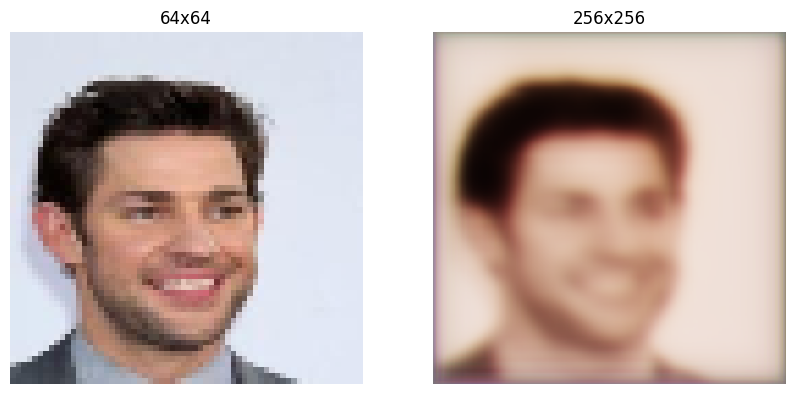

In [29]:
sample_lr, sample_hr = next(data_generator(batch_size=1))
pred_hr = model.predict(sample_lr)

# Convert back to uint8
pred_hr_img = np.clip(pred_hr[0]*255,0,255).astype(np.uint8)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("64x64")
plt.imshow((sample_lr[0]*255).astype(np.uint8))
plt.axis('off')

plt.subplot(1,2,2)
plt.title("256x256")
plt.imshow(pred_hr_img)
plt.axis('off')
plt.show()


**Why the image might be blurry:**

The predicted high-resolution image may appear blurry because the model was trained for only a limited number of epochs (5 epochs) on a small subset of the dataset (100 images). Training a super-resolution model effectively often requires significantly more data and training time to learn the complex mapping from low-resolution to high-resolution images.

To potentially improve the results and reduce blurriness, consider:

*   **Training for more epochs:** Increasing the number of training epochs allows the model to learn more from the available data.
*   **Using a larger subset of the dataset:** Training on a larger and more diverse set of images can help the model generalize better.

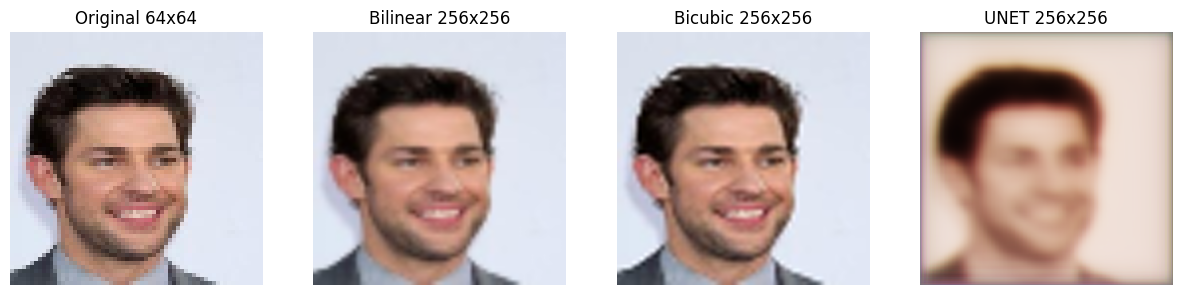

In [30]:
# Get the original low-resolution and high-resolution images from the prediction cell
# Assuming sample_lr and sample_hr are still available from the previous execution
if 'sample_lr' in locals() and 'sample_hr' in locals():

    # Resize using Bilinear interpolation
    bilinear_hr = cv2.resize((sample_lr[0]*255).astype(np.uint8), (256, 256), interpolation=cv2.INTER_LINEAR)

    # Resize using Bicubic interpolation
    bicubic_hr = cv2.resize((sample_lr[0]*255).astype(np.uint8), (256, 256), interpolation=cv2.INTER_CUBIC)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.title("Original 64x64")
    plt.imshow((sample_lr[0]*255).astype(np.uint8))
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Bilinear 256x256")
    plt.imshow(bilinear_hr)
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("Bicubic 256x256")
    plt.imshow(bicubic_hr)
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("UNET 256x256")
    # Assuming pred_hr_img is available from the previous UNET prediction
    if 'pred_hr_img' in locals():
        plt.imshow(pred_hr_img)
    else:
        plt.text(0.5, 0.5, 'Run UNET prediction cell first', horizontalalignment='center', verticalalignment='center')
    plt.axis('off')

    plt.show()
else:
    print("Please run the UNET prediction cell (UL8y0b7QbPX8) first to get sample_lr, sample_hr, and pred_hr_img.")

## Summary of Work Done:

In this notebook, we have implemented a face resolution enhancement solution using a UNET model. The steps completed include:

1.  **Dataset Download:** Downloaded the CelebA dataset using KaggleHub.
2.  **Data Preparation:** Created a data generator to load and preprocess low-resolution (64x64) and high-resolution (256x256) image pairs from a subset of the dataset.
3.  **Model Definition:** Defined the UNET model architecture for super-resolution.
4.  **Loss Function:** Defined a perceptual loss function combining pixel-wise MSE and VGG-based feature loss.
5.  **Model Training:** Compiled and trained the UNET model for 5 epochs on a small subset of 100 images.
6.  **Prediction and Comparison:** Used the trained model to predict a high-resolution image from a low-resolution input and compared the result visually with the original low-resolution image and images resized using Bicubic and Bilinear interpolation.

The initial results show that the UNET model produces a higher resolution image, but it appears blurry, likely due to the limited training data and epochs. Further training on a larger dataset is recommended to improve the results.